# Brent crude price prediction ANN model

### Getting the Data

In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
data_train = pd.read_csv('brent-daily_csv.csv', index_col="Date",parse_dates=True,nrows=8000)
data_test = pd.read_csv('brent-daily_csv.csv',index_col="Date",parse_dates=True, skiprows=[i for i in range(1,8000)], nrows=250)

### Checking the Data

In [3]:
data_test.head()

,Price
Date,
2018-11-21,61.65
2018-11-22,61.11
2018-11-23,57.69
2018-11-26,59.70
2018-11-27,59.58


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8000 entries, 1987-05-20 to 2018-11-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   8000 non-null   float64
dtypes: float64(1)
memory usage: 125.0 KB


In [5]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2018-11-21 to 2019-11-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   250 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


### Checking for any null data 

In [6]:
data_train.isnull().any()

Price    False
dtype: bool

In [7]:
data_test.isnull().any()

Price    False
dtype: bool

### Plotting the training data

In [8]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='Date'>

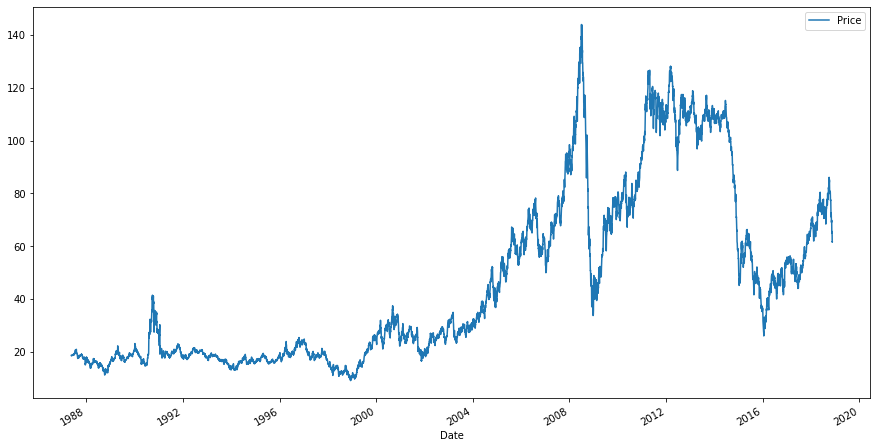

In [9]:
data_train.plot(figsize=(15,8))

### Data Preparation 

We will scale our data for optimal performance. In our case, we’ll use Scikit- Learn’s MinMaxScaler and scale our dataset to numbers between zero and one.


In [10]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set = data_train.iloc[:,0].values
training_set_scaled = sc.fit_transform(training_set.reshape(-1,1))

LSTMs expect our data to be in a specific format, usually a 3D array. We start by creating data in 60 timesteps and converting it into an array using NumPy. Next, we convert the data into a 3D dimension array with X_train samples, 60 timestamps, and one feature at each step.

In [11]:
X_train = []
y_train = []
for i in range(60, 500):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### Building LSTM model

In order to build the LSTM, we need to import a couple of modules from Keras:

- __Sequential__ for initializing the neural network
- __Dense__ for adding a densely connected neural network layer
- __LSTM__ for adding the Long Short-Term Memory layer
- __Dropout__ for adding dropout layers that prevent overfitting

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

ModuleNotFoundError: No module named 'tensorflow'

We add the LSTM layer and later add a few Dropout layers to prevent overfitting. We add the LSTM layer with the following arguments:

1. 50 units which is the dimensionality of the output space
2. return_sequences=True which determines whether to return the last output in the output sequence, or the full sequence
3. input_shape as the shape of our training set.

When defining the Dropout layers, we specify 0.2, meaning that 20% of the layers will be dropped. Thereafter, we add the Dense layer that specifies the output of 1 unit. After this, we compile our model using the popular adam optimizer and set the loss as the mean_squarred_error. This will compute the mean of the squared errors. Next, we fit the model to run on 100 epochs with a batch size of 32. Depending on the specs of the computer, this might take a few minutes to finish running.

In [297]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
14/14 [==============================] - 17s 161ms/step - loss: 7.1685e-04
Epoch 2/100
14/14 [==============================] - 2s 161ms/step - loss: 2.4876e-04
Epoch 3/100
14/14 [==============================] - 2s 161ms/step - loss: 2.1043e-04
Epoch 4/100
14/14 [==============================] - 2s 160ms/step - loss: 1.6986e-04
Epoch 5/100
14/14 [==============================] - 2s 162ms/step - loss: 1.1705e-04
Epoch 6/100
14/14 [==============================] - 2s 161ms/step - loss: 1.1190e-04
Epoch 7/100
14/14 [==============================] - 2s 161ms/step - loss: 9.0528e-05
Epoch 8/100
14/14 [==============================] - 2s 161ms/step - loss: 9.0417e-05
Epoch 9/100
14/14 [==============================] - 2s 163ms/step - loss: 7.1171e-05
Epoch 10/100
14/14 [==============================] - 2s 164ms/step - loss: 7.3868e-05
Epoch 11/100
14/14 [==============================] - 2s 176ms/step - loss: 6.8370e-05
Epoch 12/100
14/14 [==============================]

### Predicting the price using test set

In order to predict future prices we need to do a couple of things after loading in the test set:

- Merge the training set and the test set on the 0 axis.
- Set the time step as 60 (as seen previously)
- Use MinMaxScaler to transform the new dataset
- Reshape the dataset as done previously

After making the predictions we use inverse_transform to get back the stock prices in normal readable format.

In [301]:
dataset_total = pd.concat((data_train["Price"], data_test["Price"]), axis = 0)
inputs = dataset_total[len(dataset_total) - len(data_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 110):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_price = regressor.predict(X_test)
predicted_price = sc.inverse_transform(predicted_price)

### Plotting the results 

We use Matplotlib to visualize the result of the predicted stock price and the real stock price

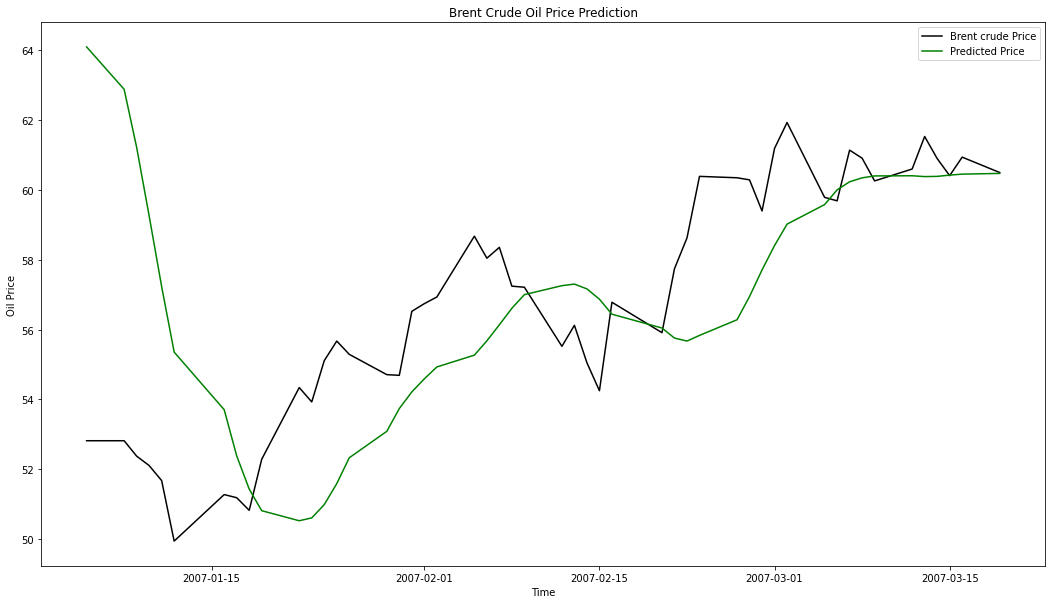

In [302]:
real_price = data_test.iloc[:, 0].values
real_price_index = data_test.index
plt.figure(figsize=(18, 10))
plt.plot(real_price_index,real_price, color = 'black', label = 'Brent crude Price')
plt.plot(real_price_index,predicted_price, color = 'green', label = 'Predicted Price')
plt.title('Brent Crude Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Oil Price')
plt.legend()
plt.show()